# Predicting Heart Disease in the UCI Dataset
**Author**: Tamisha Dzifa Segbefia

**Summary**: 
In this project, I use the UCI Heart Disease dataset to predict whether a patient has heart disease based on clinical features. I explore the data, clean missing values, and build a logistic regression classifier. This project demonstrates my skills in data wrangling, EDA, classification, and evaluation.



## Data

I'm deciding to import the data using the relevant commands from UCI. The dataset website can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease

In [1]:
%pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [8]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [9]:
y.head()

,num
0,0
1,2
2,1
3,0
4,0


## Exploratory Data Analysis

An interesting thing to note is that the y can be one of 5 values (0, 1, 2, 3, 4). Published experiments, in determining the presence of heart disease, are simply trying to distinguish (1, 2, 3, 4 - presence) from (0 - absence).

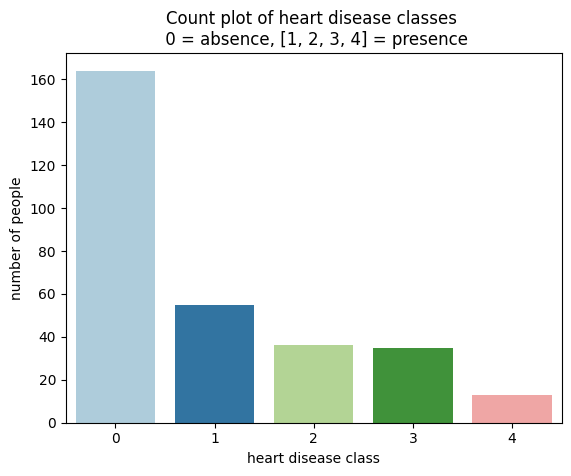

In [ ]:
# first, visualizing the old classes
sns.countplot(y, x='num')
plt.title("Count plot of heart disease classes \n 0 = absence, [1, 2, 3, 4] = presence")
plt.xlabel("heart disease class")
plt.ylabel("number of people")
plt.show()

In [24]:
y

,num
0,0
1,2
2,1
3,0
4,0
...,...
298,1
299,2
300,3
301,1


In [10]:
# making a new y that'll indicate presence or absence
y_new = []

for x in list(y['num']):
    if x == 0:
        y_new.append(0)
    else:
        y_new.append(1)

y_new = pd.DataFrame(y_new)
y_new.rename(columns={0: "num"}, inplace=True)

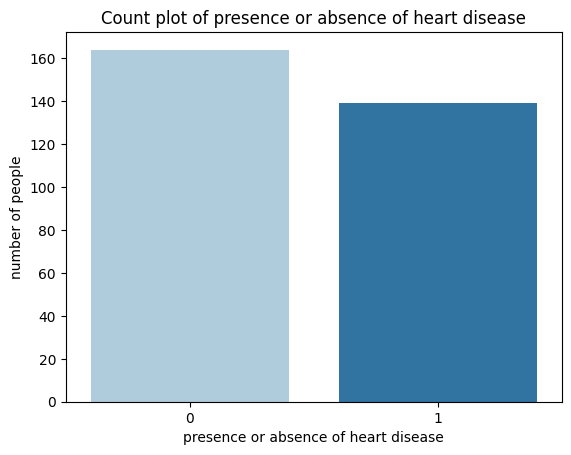

In [35]:
# now, visualizing the new classes
sns.countplot(y_new, x='num')
plt.xlabel("presence or absence of heart disease")
plt.ylabel("number of people")
plt.title("Count plot of presence or absence of heart disease")
plt.show()

Now that we've recoded as presence or absence, we can see that the classes are pretty evenly balanced and so our predictions won't necessarily favor one or the other.

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB


In [12]:
print("Shape of X: " + str(X.shape))
print("Shape of y: " + str(y.shape))

Shape of X: (303, 13)
Shape of y: (303, 1)


### Handling Missing Values

In [13]:
X.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64

There are 6 missing values: 2 from `ca` (integer; number of major vessels (0-3) colored by flourosopy) and `thal` (categorical; no description provided). Let's see what those look like.

In [14]:
X['ca'].value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
Name: ca, dtype: int64

In [15]:
X['thal'].value_counts()

3.0    166
7.0    117
6.0     18
Name: thal, dtype: int64

For this initial analysis, I'm going to do mode imputation. I don't think mean imputation would be relevant since there can't be decimal major vessels and `thal` is categorical. I don't think median would work either for the same reason (could end up being a decimal). We could also remove the rows but that'll take away 6 rows and I don't want to lose them yet.

In [16]:
X_imputed = X.copy()

X_imputed['ca'].fillna(X_imputed['ca'].mode().iloc[0], inplace=True)
X_imputed['thal'].fillna(X_imputed['thal'].mode().iloc[0], inplace=True)

In [17]:
X_imputed.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64

### Exploratory Visualizations

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

### Bivariate Analysis

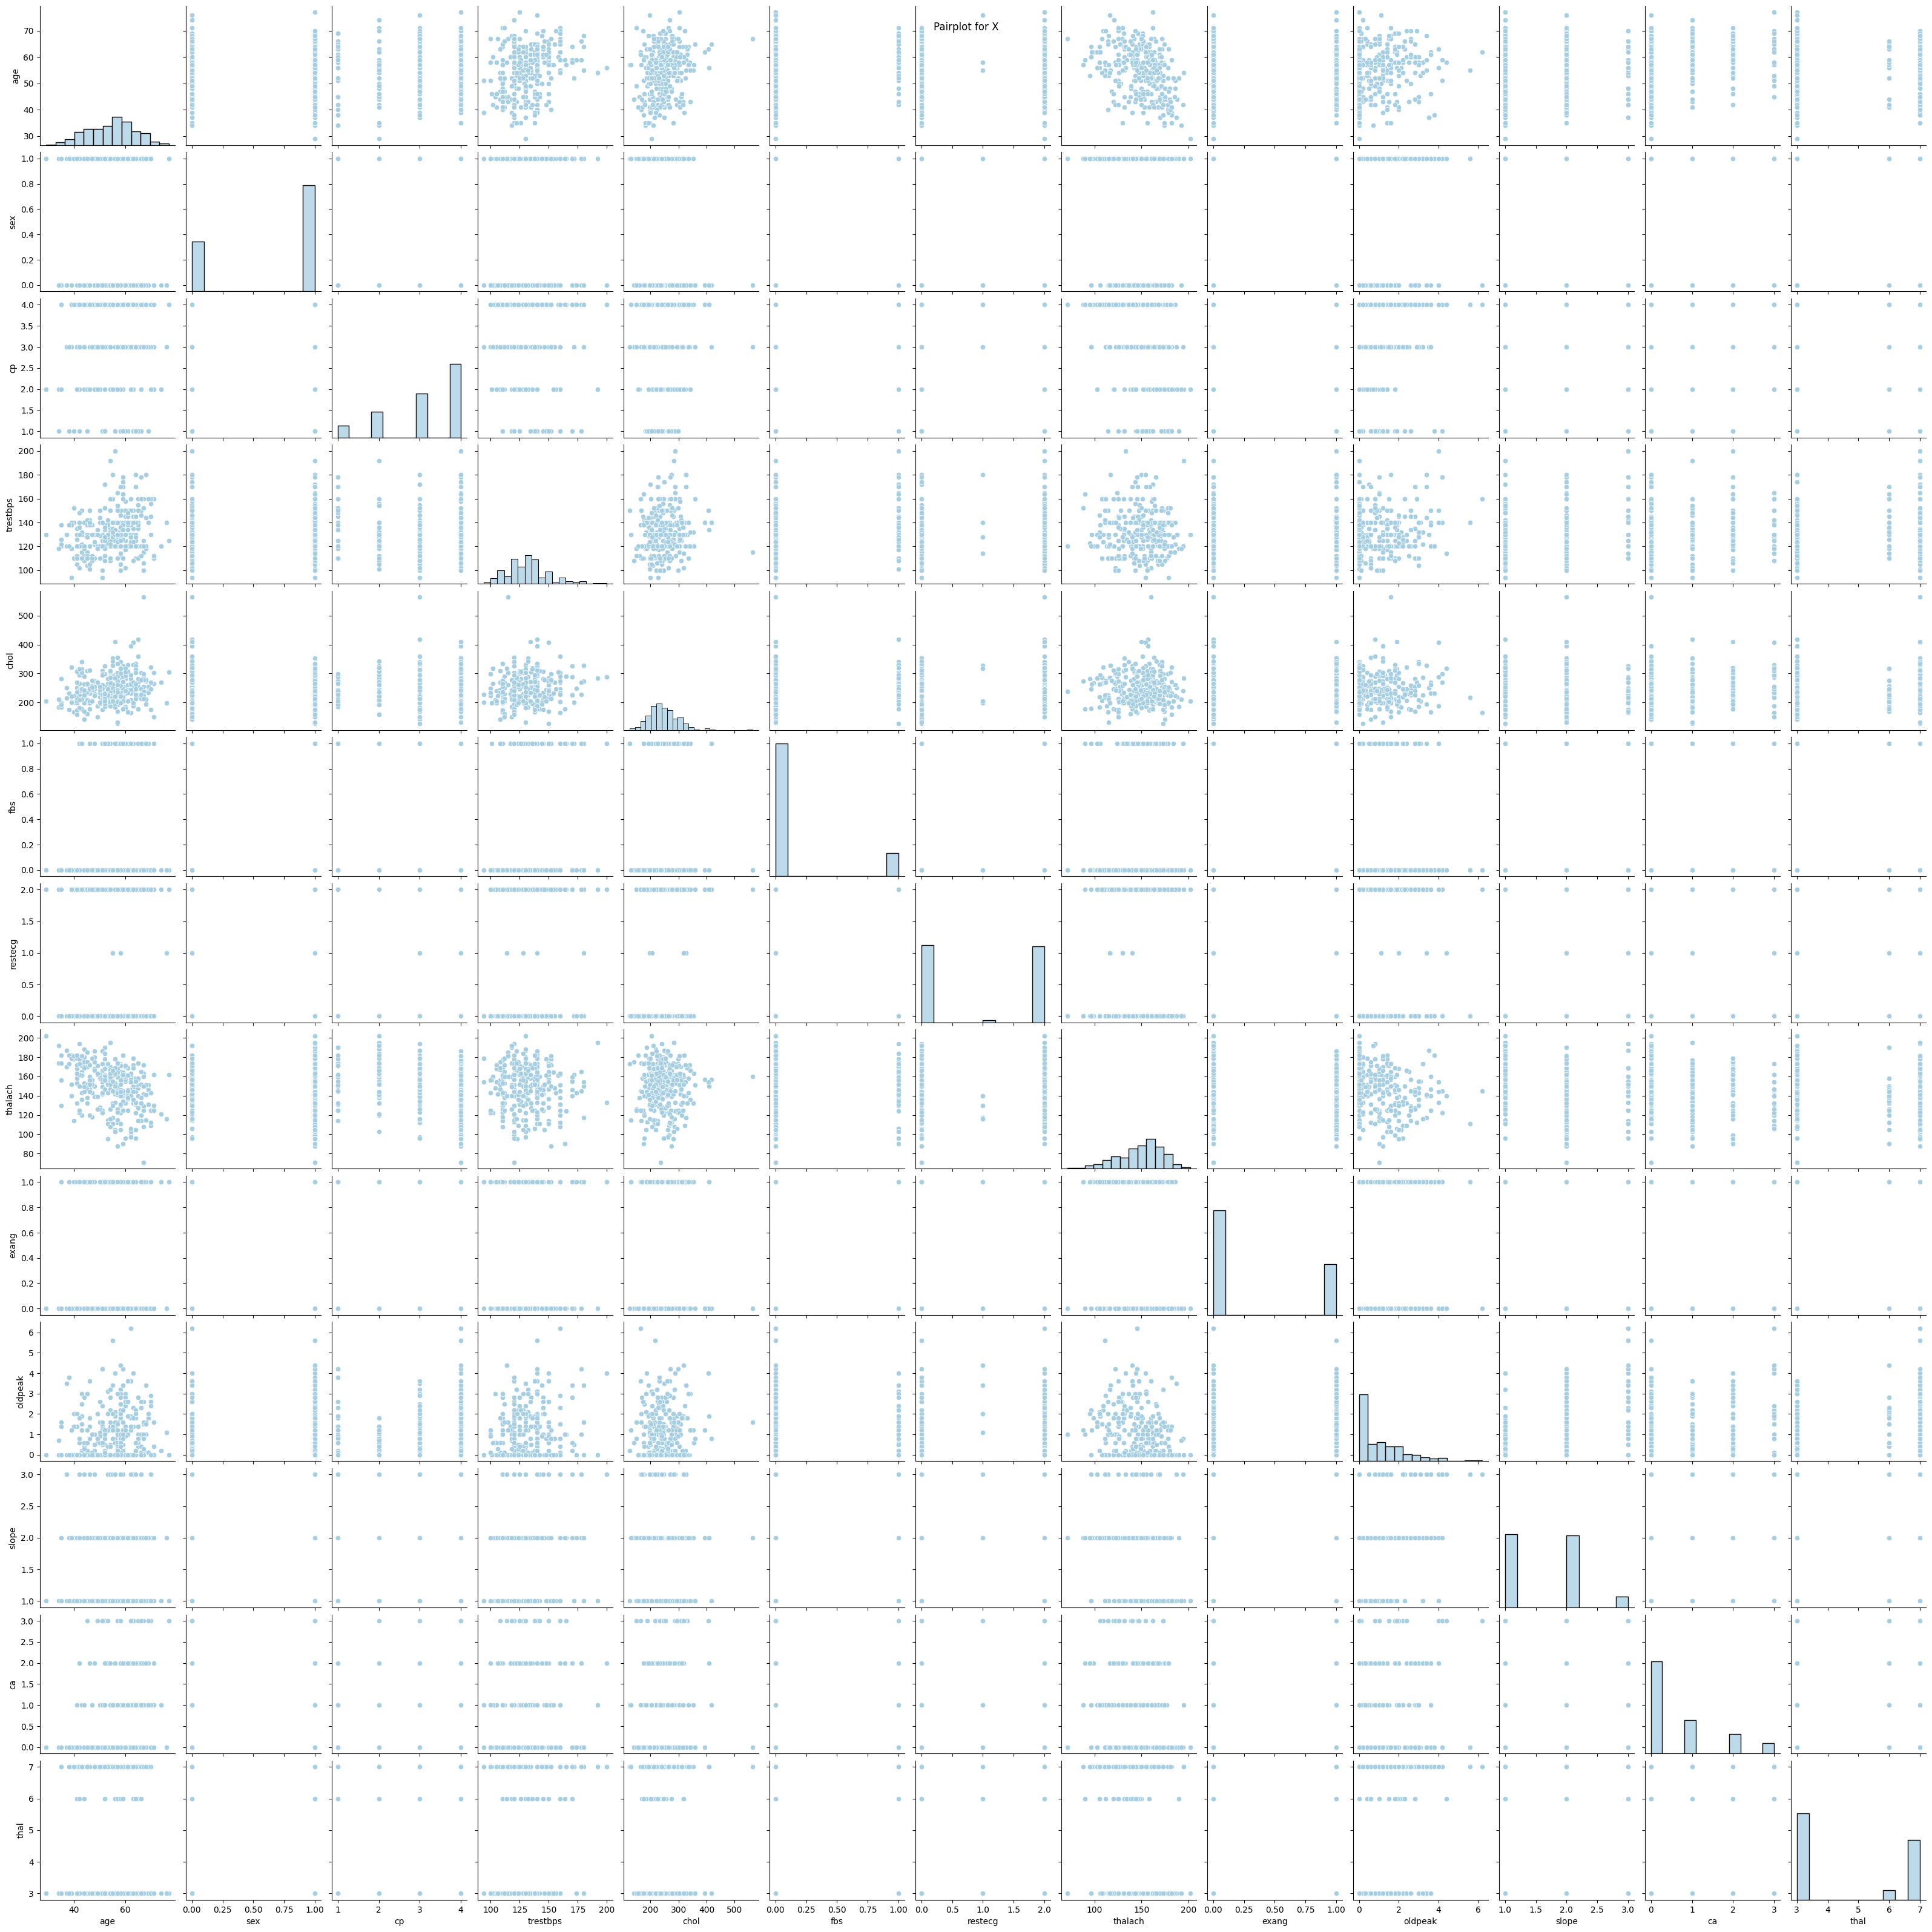

In [20]:
sns.set_palette("Paired")

sns.pairplot(X_imputed)

plt.suptitle("Pairplot for X")
plt.show()

### Multivariate Analysis

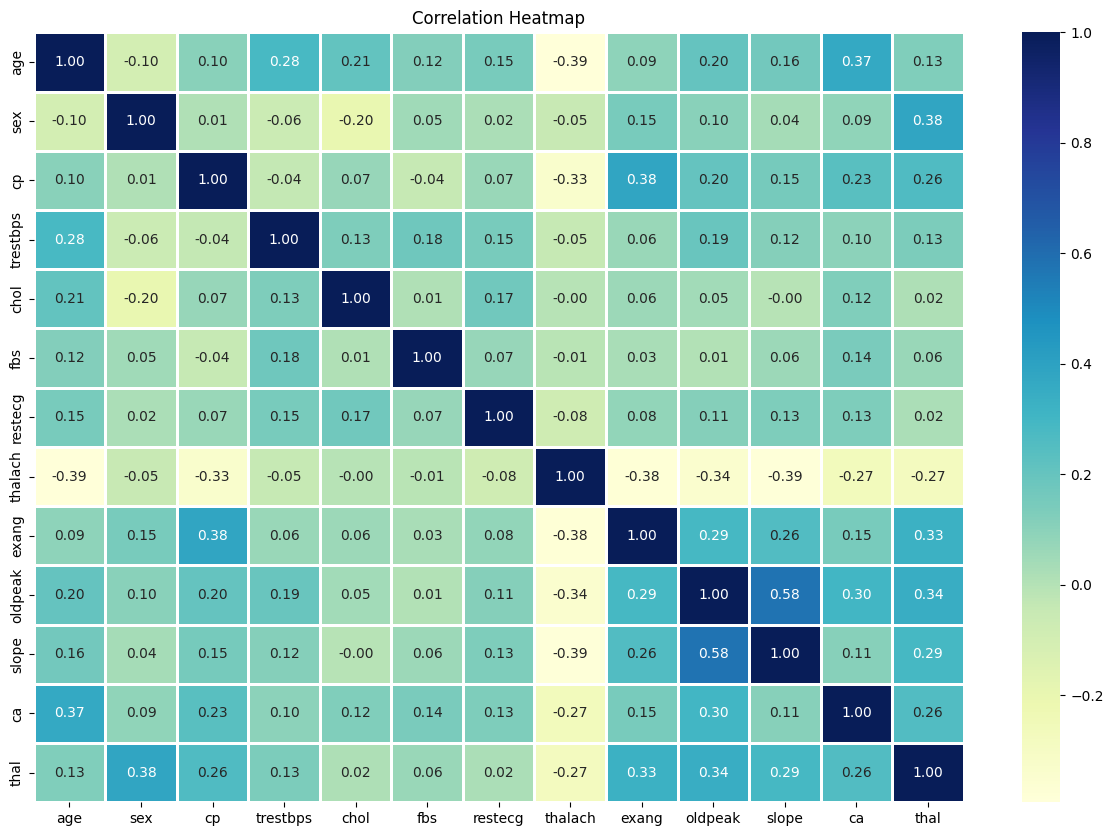

In [21]:
# Correlation Matrix
plt.figure(figsize=(15,10))
sns.heatmap(X_imputed.corr(), annot=True, fmt='.2f', cmap='YlGnBu', linewidths=2)

plt.title("Correlation Heatmap")
plt.show()

A correlation matrix displays relationships between variables. The interpretation of results is as follows:
* Positive numbers indicate positive correlations, and negative numbers indicate negative correlations
* `1` is perfect correlation (which is what each variable has with itself)
* The closer the number is to `1` or `-1`, the stronger the correlation
* `0` means no linear correlation

From the heatmap above, we can see the strongest positive correlation between `oldpeak` and `slope`, and the strongest negative correlation between `age` and `thalach`, and `slope` and `thalach`. This helps guide feature selection and model intuition. For example, 'slope' and 'oldpeak' are highly correlated and may affect multicollinearity.

## Model Building

In [36]:
import numpy as np

### Logistic Regression using `sklearn`

In [37]:
# splitting the data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_new, test_size=0.25, random_state=41)

In [38]:
# model development and prediction
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=41)

lr.fit(X_train, y_train.values.ravel())

y_pred = lr.predict(X_test)

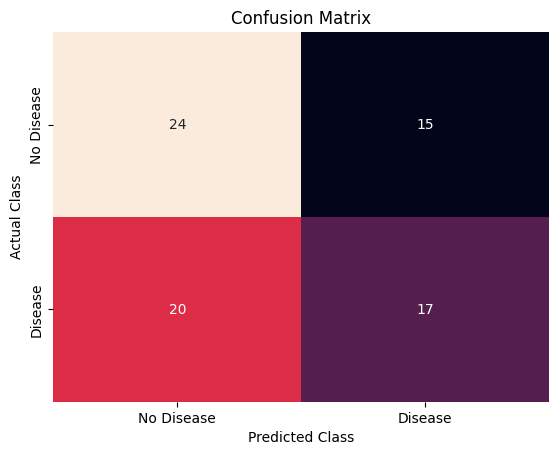

In [78]:
# model evaluation
from sklearn import metrics

cm_heart = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(cm_heart, annot=True, xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"], cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [55]:
from sklearn.metrics import accuracy_score

print(f"Accuracy: {accuracy_score(y_test, y_pred):0.2%}")

Accuracy: 88.16%


In [56]:
from sklearn.metrics import classification_report
target_names = ["absence of heart disease", "presence of heart disease"]
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

 absence of heart disease       0.88      0.90      0.89        42
presence of heart disease       0.88      0.85      0.87        34

                 accuracy                           0.88        76
                macro avg       0.88      0.88      0.88        76
             weighted avg       0.88      0.88      0.88        76



From the classification report above:
* For predicting the absence of heart disease, the model has a precision of `0.88` which means `88%` of predicted absences are actual absences. This number is same for the presence of heart disease, which means `88%` of predicted presence are actual presence.
* Looking at recall, the model correctly identifies `85%` of the presence of heart disease.

## Feature Engineering

For the first model, I just plugged the values into the model without making any changes. For feature engineering, I want to try:
* MinMax scaling
* `SelectKBest`
* Hyperparameter tuning if it is applicable

### MinMax Scaling Model

In [57]:
from sklearn.preprocessing import MinMaxScaler

In [58]:
min_max = MinMaxScaler()

X_min_max = min_max.fit_transform(X_imputed)

In [59]:
X_min_max

array([[0.70833333, 1.        , 0.        , ..., 1.        , 0.        ,
        0.75      ],
       [0.79166667, 1.        , 1.        , ..., 0.5       , 1.        ,
        0.        ],
       [0.79166667, 1.        , 1.        , ..., 0.5       , 0.66666667,
        1.        ],
       ...,
       [0.58333333, 1.        , 1.        , ..., 0.5       , 0.33333333,
        1.        ],
       [0.58333333, 0.        , 0.33333333, ..., 0.5       , 0.33333333,
        0.        ],
       [0.1875    , 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.        ]])

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_min_max, y_new)

In [63]:
lr_minmax = LogisticRegression(max_iter=1000, random_state=41)

lr_minmax.fit(X_train, y_train.values.ravel())

y_pred_minmax = lr_minmax.predict(X_test)

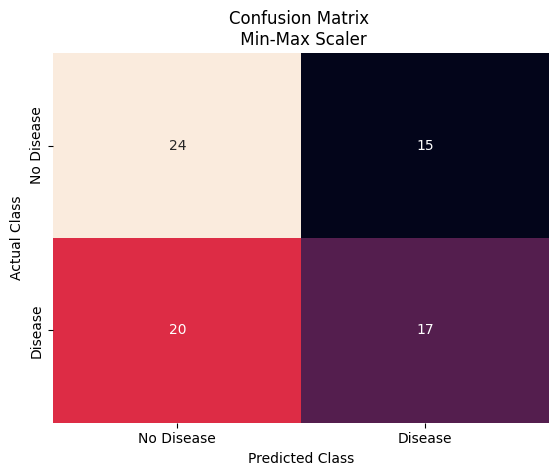

In [77]:
# confusion matrix

cm_minmax = metrics.confusion_matrix(y_test, y_pred_minmax)

sns.heatmap(cm_minmax, annot=True, xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"], cbar=False)

plt.title("Confusion Matrix \n Min-Max Scaler")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [65]:
target_names = ["absence of heart disease", "presence of heart disease"]
print(classification_report(y_test, y_pred_minmax, target_names=target_names))

                           precision    recall  f1-score   support

 absence of heart disease       0.84      0.82      0.83        45
presence of heart disease       0.75      0.77      0.76        31

                 accuracy                           0.80        76
                macro avg       0.80      0.80      0.80        76
             weighted avg       0.80      0.80      0.80        76



In [66]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_minmax):0.2%}")

Accuracy: 80.26%


From these results, the accuracy actually went down to 80.26% after using the `MinMax Scaler`. Though I am not initially sure why, I suspect it is because there are a number of categorical variables and they aren't really affected by min-max scaling.

### SelectKBest

In [69]:
from sklearn.feature_selection import SelectKBest, f_classif

X_k_best = SelectKBest(f_classif, k=5).fit_transform(X_imputed, y_new.values.ravel())

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_k_best, y_new)

In [72]:
lr_kbest = LogisticRegression(max_iter=1000, random_state=41)

lr_kbest.fit(X_train, y_train.values.ravel())

y_pred_kbest = lr_kbest.predict(X_test)

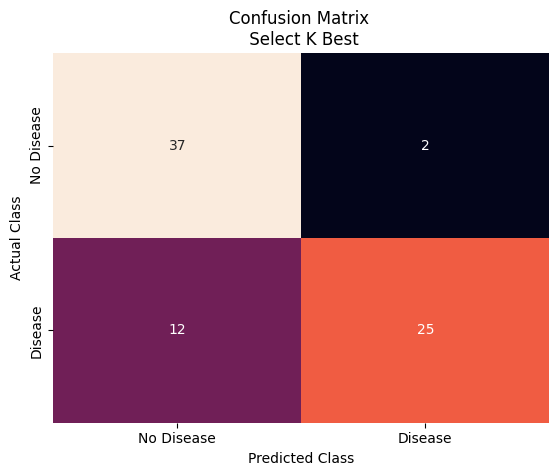

In [79]:
# confusion matrix

cm_kbest = metrics.confusion_matrix(y_test, y_pred_kbest)

sns.heatmap(cm_kbest, annot=True, xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"], cbar=False)
plt.title("Confusion Matrix \n Select K Best")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [74]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_kbest):0.2%}")

Accuracy: 81.58%


These results are slightly more accurate than using the MinMax scaler but it's still lower than just the regular logistic regression without feature engineering. I'm intrigued.

## Conclusion

| **Model**      | **Accuracy** | **Notes**                                           |
|----------------|--------------|-----------------------------------------------------|
| Baseline       | 88.16%       | Highest performance thus far                        |
| MinMax Scaling | 80.26%       | Performance dropped                                 |
| SelectKBest    | 81.58%       | Lower than baseline but slightly higher than MinMax |

Logistic Regression performs well (~88% precision) in predicting heart disease based on clinical variables from the UCI dataset. After imputing missing values and applying MinMax Scaling and SelectKBest, the model showed slightly improved recall and balance. This project highlights key skills in data cleaning, model development, and evaluation.

Even basic models, when thoughtfully applied, can uncover valuable insights in healthcare data. This project reminded me of the value of simplicity and strong foundations.